# Computer Vision: Assignment-2

## Mudit Dhawan (2018159) 

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Q2

Importing required Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import tqdm

In [3]:
import skimage.io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import measure
from skimage.color import label2rgb

In [4]:
from sklearn import cluster

In [5]:
from math import pi

In [6]:
def read_image_set(img_name_list):
    images = []
    
    ## Read the images
    for file_name in img_name_list:
        images.append(skimage.io.imread(fname=file_name)[:,:,:3])
    
    return images 

In [7]:
## Visualize the output
def show_image_set_output(out_list, cmap=None, title=None):
    
    for out in out_list:
        plt.imshow(out, cmap=cmap)
        plt.title(title)
        plt.show()

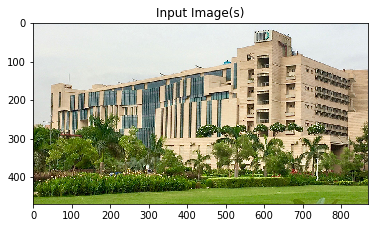

In [8]:
# read image
img_name_list = ["example.jpg"]
# img_name_list = ["Cap1.png", "Cap2.png"]
images = read_image_set(img_name_list)

show_image_set_output(images, title="Input Image(s)")

In [43]:
def find_super_pixels(image_list, n_segments=300, sigma=1, start_label=1):
    segments_slics = []
    
    for image in image_list:
        ## find slic superpixels for the image
        segments_slics.append(slic(image, n_segments=n_segments, sigma=sigma, start_label=start_label))
        
    return segments_slics

In [44]:
def find_boundaries_super_pixels(image_list, slic_segment_list):
    image_super_pixel_boundaries = []
    
    ## Create the boundary map for the super pixels
    for image, segments_slic in zip(image_list, slic_segment_list):
        image_super_pixel_boundaries.append(mark_boundaries(image, segments_slic))
    
    return image_super_pixel_boundaries

In [45]:
segments_slics = find_super_pixels(images) ## Find the Super Pixels for the given Image(s)

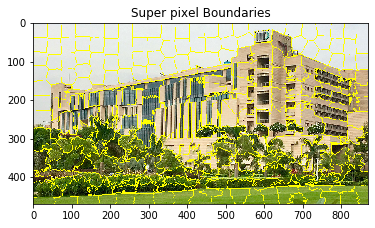

In [46]:
## Find the Boundary for fuper Pixels for the given Image(s)
boundaries = find_boundaries_super_pixels(images, segments_slics)  

## Visualize the output
show_image_set_output(boundaries, title="Super pixel Boundaries")

In [47]:
## Find the average colour for the super pixels
def find_avg_image_super_pixels(image_list, slic_segment_list):
    image_super_pixel_avgs = []
    
    for image, segments_slic in zip(image_list, slic_segment_list):
        image_super_pixel_avgs.append(label2rgb(segments_slic, image, kind='avg', bg_label=0)/255)
    
    return image_super_pixel_avgs

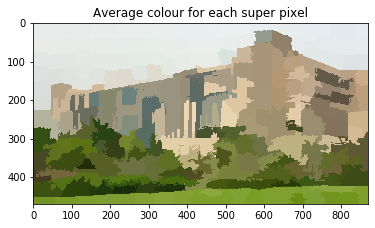

In [48]:
## Find the average colour for the super pixels
avg_super_pixels = find_avg_image_super_pixels(images, segments_slics) 

show_image_set_output(avg_super_pixels, title="Average colour for each super pixel")

In [49]:
## Create an array containing average colour for each super-pixel -> used for clustering
def create_avg_colour_sp_array(images, segments_slics):
    avg_colours_super_pixels = [] ## Store 
    
    avg_imgs = find_avg_image_super_pixels(images, segments_slics) 
    
    for avg_img, segments_slic in zip(avg_imgs, segments_slics):
        
        ## Loop over all the superpixel numbers
        for label in np.unique(segments_slic):
            
            ## Find coordinates of pixels in a super pixel
            pos_x, pos_y = np.where(segments_slic == label)

            avg_colour = avg_img[pos_x[0], pos_y[0],:] ## find the avg colour of the pixel
            
            avg_colours_super_pixels.append(avg_colour)
    
    return avg_colours_super_pixels

In [50]:
## Create an array containing average colour for each super-pixel -> used for clustering
avg_colours_super_pixels = create_avg_colour_sp_array(images, segments_slics)

In [51]:
## Function to perform clustering on the given Image(s)
def perform_clustering(colours_list, n_clusters = 20):
    
    clf = cluster.KMeans(n_clusters=n_clusters)
    
    clf.fit(np.array(colours_list))
    
    return clf.cluster_centers_, clf.labels_

In [52]:
## perform clustering on the given Image(s)
cluster_centers, labels = perform_clustering(avg_colours_super_pixels, n_clusters = 10)

In [53]:
## Assign the cluster colour values to corresponding super pixels for Image(s)
def create_clustered_image(segments_slics, cluster_centers, labels):
    
    clustered = cluster_centers[labels] ## map super pixel avg colour with cluster label
    
    clustered_images_super_pixel = []
    
    ## Store the size of each array (number of super-pixels)
    nb_super_pixel_image = [0] + [len(np.unique(segments_slic)) for segments_slic in segments_slics]
    
    nb_super_pixel_image = np.cumsum(nb_super_pixel_image)
    for idx, segments_slic in enumerate(segments_slics):
        
        ## slice superpixels corresponding to a particular image
        clustered_images_super_pixel_arr = clustered[nb_super_pixel_image[idx]: nb_super_pixel_image[idx+1], :] 
        
        ## create and image corresponding to the cluster labels and super pixels
        clustered_images_super_pixel.append(label2rgb(segments_slics[idx], colors=clustered_images_super_pixel_arr))
        
    return clustered_images_super_pixel

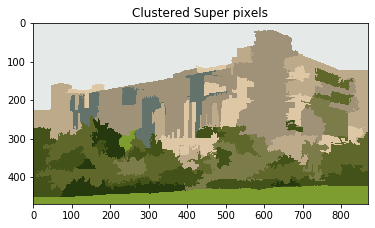

In [54]:
## Create clustered image maps 
clustered_images_super_pixel = create_clustered_image(segments_slics, cluster_centers, labels)

show_image_set_output(clustered_images_super_pixel, title="Clustered Super pixels")

In [55]:
def find_contrast_cue(images, cluster_centers, labels):
    
    ## Find the count of each label 
    _, weights = np.unique(labels, return_counts=True) 
    weights = weights / labels.shape[0] ## Normalize
    
    contrast_cue = [] ## Stor contrast cue for each cluster 
    
    ## Loop over each cluster 
    for k in range(cluster_centers.shape[0]):
        
        ## the centroid (colour) of the cluster
        curr_cluster_center = cluster_centers[k,:].reshape((1,3))
        
        repeated = np.repeat(curr_cluster_center, repeats=cluster_centers.shape[0], axis=0)
        
        ## Find the distance of the center of the current cluster with each other cluster center
        dist_vector = np.linalg.norm(repeated - cluster_centers, axis=1)
        
        ## Store the weighted average distance from each cluster -> contrast cue
        contrast_cue.append(np.average(dist_vector, axis=0, weights=weights))
    
    contrast_cue = contrast_cue/max(contrast_cue)
    
    return contrast_cue

In [56]:
## Calculate the contrast cue for each cluster 
contrast_cue = find_contrast_cue(images, cluster_centers, labels)

In [57]:
## function to create feature maps for each image coreesponding the clusters and super-pixels
def create_feature_map(feature_list, labels, segments_slics):
    
    feature_maps =[]
    
    ## find feature value corresponding to each super pixel 
    features_label = np.array(feature_list)[labels]
    
    ## Store the size of each array (number of super-pixels)
    nb_super_pixel_image = [0] + [len(np.unique(segments_slic)) for segments_slic in segments_slics]
    
    nb_super_pixel_image = np.cumsum(nb_super_pixel_image)
    
    for idx, segments_slic in enumerate(segments_slics):
        
        ## slice superpixels corresponding to a particular image
        images_feature = features_label[nb_super_pixel_image[idx]: nb_super_pixel_image[idx+1]]
        
        ## use the values corresponding to each super-pixel to create a corresponding image
        feature_maps.append(images_feature[segments_slic-1])
        
    return feature_maps, features_label

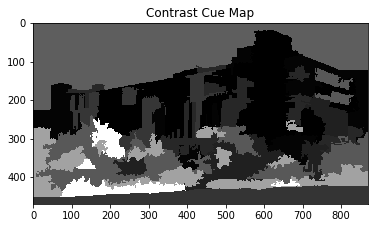

In [58]:
## Create contrast feature map corresponding to the contrast cue
contrast_cue_feature, images_contrast_array = create_feature_map(contrast_cue, labels, segments_slics)

show_image_set_output(contrast_cue_feature, cmap='gray', title="Contrast Cue Map")

In [59]:
## Function to find normal distance for spatial cue
def calculate_normal_distance(x, mean=0, var=0.01):
    exponent = np.exp(-((x-mean)**2 / (2 * var )))

    return (1 / (np.sqrt(2 * pi* var))) * exponent

In [60]:
## Create normal distribution maps for the gicen image (location from the center)
def calculate_normal_image_maps(images, segments_slics):
    
    normal_loc_images = [] ## Store distance of super-pixels from center in a flattened form
    
    normal_loc_image_maps = [] ## Store distance of super-pixels from center in a 2D form
    
    ## Loop over all the images
    for image, segments_slic in zip(images, segments_slics):
        
        ## Find properties for each super pixel
        regions = measure.regionprops(segments_slic, intensity_image=image)
        
        centroids = [r.centroid for r in regions] ## Find the centroids
        
        ## Array containing position of each super pixel
        image_locs = np.array(centroids)
        
        ## Normalizing the positionc
        image_locs[:,0] = image_locs[:,0] / image.shape[0]
        image_locs[:,1] = image_locs[:,1] / image.shape[1]

        ## Creating an array with pixel values as the center of the image
        center_image_loc = np.ones((len(np.unique(segments_slic)), 2))
        center_image_loc[:,0] = center_image_loc[:,0] * (image.shape[0] // 2) / image.shape[0]
        center_image_loc[:,1] = center_image_loc[:,1] * (image.shape[1] // 2) / image.shape[1]
        
        ## Calculate distance of each super-pixel position from teh center
        dist_image_locs = (np.linalg.norm(image_locs - center_image_loc, axis=1))**2
        
        ## apply normaldistribution on the distances
        dist_image_locs = calculate_normal_distance(dist_image_locs)
        
        ## Store 2D map 
        normal_loc_image_maps.append(dist_image_locs[segments_slic-1])
        
        ## Store flattened map
        normal_loc_images.append(dist_image_locs.flatten())
    
    normal_loc_images = np.concatenate(normal_loc_images, axis=0)
    
    return normal_loc_images, normal_loc_image_maps

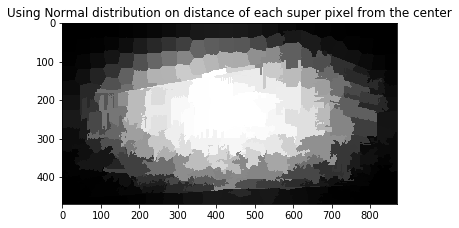

In [61]:
## Calculate the normal function value for each super pixel
normal_loc_images, normal_loc_image_maps = calculate_normal_image_maps(images, segments_slics)

show_image_set_output(normal_loc_image_maps, cmap='gray', title="Using Normal distribution on distance of each super pixel from the center")

In [62]:
## Function to find the spatial cue of image(s)
def find_spatial_cue(images, segments_slics, cluster_centers, labels):
    
    spatial_cue = [] ## store the cue 
    
    ## Develop the normal maps for the given image(s)
    normal_loc_images, normal_loc_image_maps = calculate_normal_image_maps(images, segments_slics)
    
    ## Calculate weights corresponding to the clusters (number of superpixels in a cluster)
    _, weights = np.unique(labels, return_counts=True) 
    
    for k in range(cluster_centers.shape[0]):
        ## For each cluster calculate the spatial cue
        spatial_cue.append(np.sum(normal_loc_images[labels == k]) / weights[k])
    
    spatial_cue = spatial_cue/max(spatial_cue)  ## Normalize 
    
    return spatial_cue

In [63]:
## calculate the spatial cue 
spatial_cue = find_spatial_cue(images, segments_slics, cluster_centers, labels)

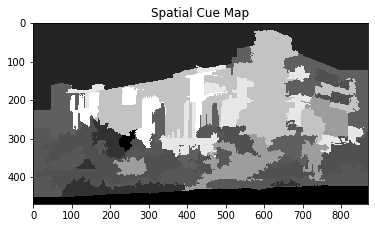

In [64]:
## Create contrast feature map corresponding to the spatial cue
spatial_cue_feature, images_spatial_array = create_feature_map(list(spatial_cue), labels, segments_slics)

show_image_set_output(spatial_cue_feature, cmap='gray', title="Spatial Cue Map")

In [65]:
## Calculate un-weighted saliency cue for the image(s)
saliency_cue =  list(np.array(contrast_cue)*spatial_cue)

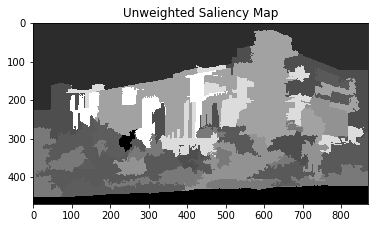

In [66]:
## Create contrast feature map corresponding to the saliency cue
saliency_cue_feature, images_saliency_array = create_feature_map(saliency_cue, labels, segments_slics)

show_image_set_output(saliency_cue_feature, cmap='gray', title="Unweighted Saliency Map")

# Q3

Importing required Libraries

In [67]:
from skimage import filters
from skimage import exposure

In [68]:
from scipy.stats import norm
from scipy import integrate 

In [69]:
from math import pi, log10

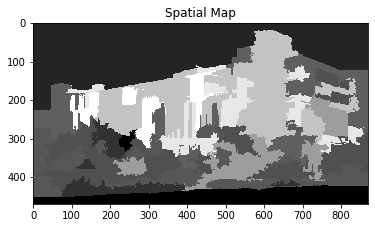

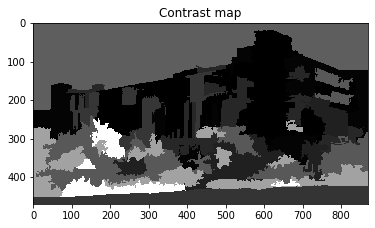

In [70]:
## Show the spatial and contrast cue maps for the image(s) 
for img_spatial_map, img_contrast_map in zip(spatial_cue_feature, contrast_cue_feature):
    
    ## Spatial Maps
    
    plt.imshow(img_spatial_map, cmap='gray')
    plt.title("Spatial Map")
    plt.show()
    
    ## Contrast maps
    
    plt.imshow(img_contrast_map, cmap='gray')
    plt.title("Contrast map")
    plt.show()
    

In [71]:
## Ccalculate the stats (mean and std) for the likeelihoods
def create_stats_likelihood(img_cue_map):
    
    ## Use Otsu for finding likelihoods
    otsu_threshold = filters.threshold_otsu(img_cue_map)
    
    ## Lower than threshold -> bg
    stats_lower = np.mean(img_cue_map[img_cue_map < otsu_threshold]), np.std(img_cue_map[img_cue_map < otsu_threshold])
    
    ## Higher than threshold -> fg
    stats_upper = np.mean(img_cue_map[img_cue_map >= otsu_threshold]), np.std(img_cue_map[img_cue_map >= otsu_threshold])
    
    return stats_lower, stats_upper

In [72]:
## Create the likelihood functions
def create_distribution(stats_lower, stats_upper, dx=0.01):
    
    ## Create an x-axis for the likelihoods
    x_axis = np.arange(0, 1, dx)
    
    ## If just single bin > 0 for a likelihood map -> std=0
    if stats_lower[1]==0.0 or stats_upper[1]==0.0:
        print("Distribtuion just a single line")
        return 0
    
    else: 
        ## Find the likelihoods
        dist_lower = norm.pdf(x_axis,stats_lower[0],stats_lower[1]) 
        dist_upper = norm.pdf(x_axis,stats_upper[0],stats_upper[1])

        ## Visualize from [0,1]
        plt.plot(x_axis, dist_lower, label="BG")
        plt.plot(x_axis, dist_upper, label="FG")
        plt.title("Likelihood Distributions")
        plt.legend()
        plt.show()
    
        return x_axis, dist_lower, dist_upper

In [73]:
## Calculate the separation measure given likelihood functions
def find_overlap(x_axis, dist_lower, dist_upper):
    
    ## Overlap curve
    common_curve = np.minimum(dist_lower, dist_upper)
    
    ## Visualize
    plt.plot(x_axis, common_curve)
    plt.title("Curve denoting the Overlapping area")
    plt.show()
    
    ## Overlap area 
    L_S = integrate.simps(common_curve, x_axis)
    
    phi_S = 1 / (1 + math.log10(1 + 255*L_S))
#     print("Quality:", phi_S)
    
    return phi_S

In [74]:
## Calculate the Quality (separation measure) for a given cue map 
def find_separation_measure(img_cue_map):
    
    ## Calculate the statistics for the bg and fg likelihoods
    stats_lower, stats_upper = create_stats_likelihood(img_cue_map)
    
    try:
        ## Create the distribution (if std != 0)
        x_axis, dist_lower, dist_upper = create_distribution(stats_lower, stats_upper, dx=0.01)
    except:
        ## if std == 0 -> overlap area = 0 -> separation measure = 1
        return 1
    
    phi_S = find_overlap(x_axis, dist_lower, dist_upper)
    
    return phi_S

In [75]:
## Calculate the weighted saliency map for Image(s)
def calculate_weighted_saliency(spatial_cue_feature, contrast_cue_feature):
    
    ## Loop over all the image(s)' contrast and spatial maps
    for img_spatial_map, img_contrast_map in zip(spatial_cue_feature, contrast_cue_feature):
        
        print("Calculating separation measure for Spatial Map")
        quality_spatial = find_separation_measure(img_spatial_map)
        print("Quality (Separation measure) for spatial map:", quality_spatial)
        
        print("Calculating separation measure for Contrast Map")
        quality_contrast = find_separation_measure(img_contrast_map)
        print("Quality (Separation measure) for contrast map:", quality_contrast)
        
        weighted_saliency = (quality_spatial*img_spatial_map + quality_contrast*img_contrast_map) / (quality_spatial + quality_contrast)
        
        ## Visulaize the weighted saliency map
        plt.imshow(weighted_saliency, cmap='gray')
        plt.title("Weighted Saliency Map")
        plt.show()

Calculating separation measure for Spatial Map


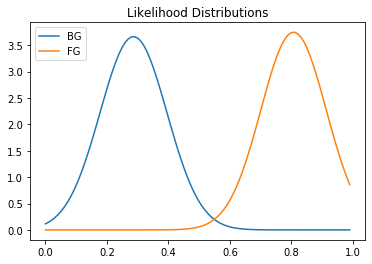

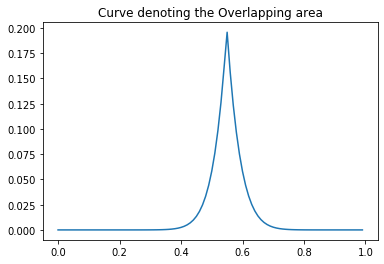

Quality (Separation measure) for spatial map: 0.5889876435976329
Calculating separation measure for Contrast Map


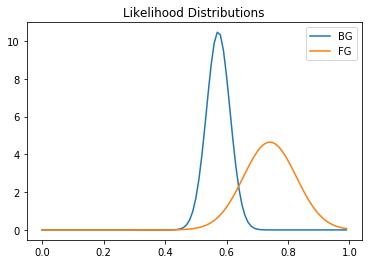

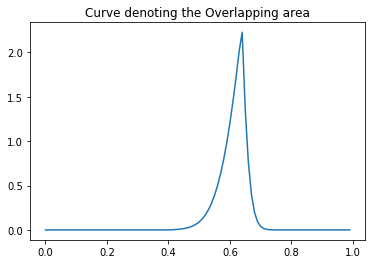

Quality (Separation measure) for contrast map: 0.3818487027403103


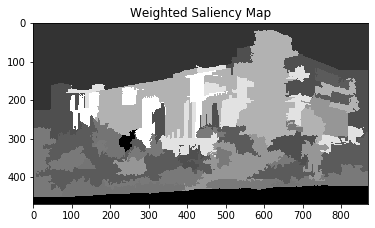

In [76]:
## Calculate the weighted saliency map
calculate_weighted_saliency(spatial_cue_feature, contrast_cue_feature)